In [1]:
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from santander.utils import ColumnDropper
from santander.utils import ZERO_VARIANCE_COLUMNS, CORRELATED_COLUMNS

In [4]:
df_train = pd.read_csv('../data/train.csv')
df_target = df_train['TARGET']
df_train = df_train.drop(['TARGET', 'ID'], axis=1)

[0]	validation_0-auc:0.793093
[1]	validation_0-auc:0.797413
[2]	validation_0-auc:0.798192
[3]	validation_0-auc:0.798620
[4]	validation_0-auc:0.801204
[5]	validation_0-auc:0.801672
[6]	validation_0-auc:0.801672
[7]	validation_0-auc:0.801672
[8]	validation_0-auc:0.803535
[9]	validation_0-auc:0.808460
[10]	validation_0-auc:0.809280
[11]	validation_0-auc:0.809030
[12]	validation_0-auc:0.808940
[13]	validation_0-auc:0.808390
[14]	validation_0-auc:0.811569
[15]	validation_0-auc:0.811916
[16]	validation_0-auc:0.811457
[17]	validation_0-auc:0.814898
[18]	validation_0-auc:0.814982
[19]	validation_0-auc:0.815722
[20]	validation_0-auc:0.815880
[21]	validation_0-auc:0.816649
[22]	validation_0-auc:0.817542
[23]	validation_0-auc:0.819022
[24]	validation_0-auc:0.819409
[25]	validation_0-auc:0.820612
[26]	validation_0-auc:0.821179
[27]	validation_0-auc:0.820873
[28]	validation_0-auc:0.821377
[29]	validation_0-auc:0.821020
[30]	validation_0-auc:0.821666
[31]	validation_0-auc:0.822443
[32]	validation_0-

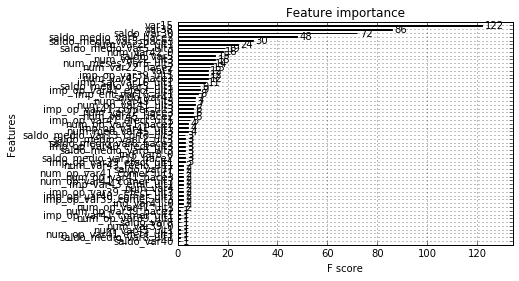

In [5]:
# xgb on raw features
# TODO: plot train/test to tune

X_train = df_train.copy()
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)
xgb = XGBClassifier(seed=0)
xgb = xgb.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)])

plot_importance(xgb)

[0]	validation_0-auc:0.793093
[1]	validation_0-auc:0.797413
[2]	validation_0-auc:0.798192
[3]	validation_0-auc:0.798620
[4]	validation_0-auc:0.801204
[5]	validation_0-auc:0.801672
[6]	validation_0-auc:0.801672
[7]	validation_0-auc:0.801672
[8]	validation_0-auc:0.803535
[9]	validation_0-auc:0.808460
[10]	validation_0-auc:0.809280
[11]	validation_0-auc:0.809030
[12]	validation_0-auc:0.808940
[13]	validation_0-auc:0.808390
[14]	validation_0-auc:0.811569
[15]	validation_0-auc:0.811916
[16]	validation_0-auc:0.811457
[17]	validation_0-auc:0.814898
[18]	validation_0-auc:0.814982
[19]	validation_0-auc:0.815722
[20]	validation_0-auc:0.815880
[21]	validation_0-auc:0.816649
[22]	validation_0-auc:0.817542
[23]	validation_0-auc:0.819022
[24]	validation_0-auc:0.819409
[25]	validation_0-auc:0.820612
[26]	validation_0-auc:0.821179
[27]	validation_0-auc:0.820873
[28]	validation_0-auc:0.821377
[29]	validation_0-auc:0.821020
[30]	validation_0-auc:0.821666
[31]	validation_0-auc:0.822443
[32]	validation_0-

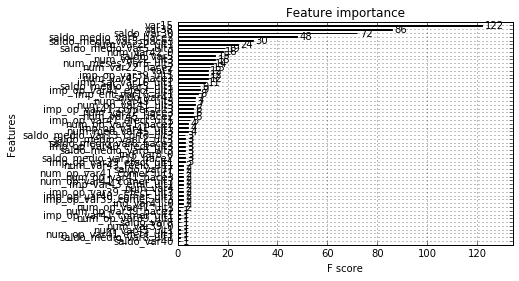

In [9]:
# xgb on dropped features
# TODO: plot train/test to tune

pipeline = Pipeline([
        ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS))
    ])

pipeline = pipeline.fit(df_train)
X_train = pipeline.transform(df_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)
xgb = XGBClassifier(seed=0)
xgb = xgb.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)])

plot_importance(xgb)

In [7]:
# sklearn gradient boosted trees
# TODO: plot feature importances, train/test, ROC vs xgboost
# gb = GradientBoostingClassifier()
# gb = gb.fit(X_train, y_train)

[0]	validation_0-auc:0.754549
[1]	validation_0-auc:0.761934
[2]	validation_0-auc:0.761681
[3]	validation_0-auc:0.768873
[4]	validation_0-auc:0.770985
[5]	validation_0-auc:0.771945
[6]	validation_0-auc:0.773140
[7]	validation_0-auc:0.773372
[8]	validation_0-auc:0.774302
[9]	validation_0-auc:0.775300
[10]	validation_0-auc:0.775574
[11]	validation_0-auc:0.775625
[12]	validation_0-auc:0.775019
[13]	validation_0-auc:0.775688
[14]	validation_0-auc:0.777264
[15]	validation_0-auc:0.777077
[16]	validation_0-auc:0.777485
[17]	validation_0-auc:0.777234
[18]	validation_0-auc:0.777718
[19]	validation_0-auc:0.778715
[20]	validation_0-auc:0.780436
[21]	validation_0-auc:0.780686
[22]	validation_0-auc:0.784322
[23]	validation_0-auc:0.784135
[24]	validation_0-auc:0.787033
[25]	validation_0-auc:0.790377
[26]	validation_0-auc:0.791325
[27]	validation_0-auc:0.792411
[28]	validation_0-auc:0.793636
[29]	validation_0-auc:0.796238
[30]	validation_0-auc:0.796853
[31]	validation_0-auc:0.798208
[32]	validation_0-

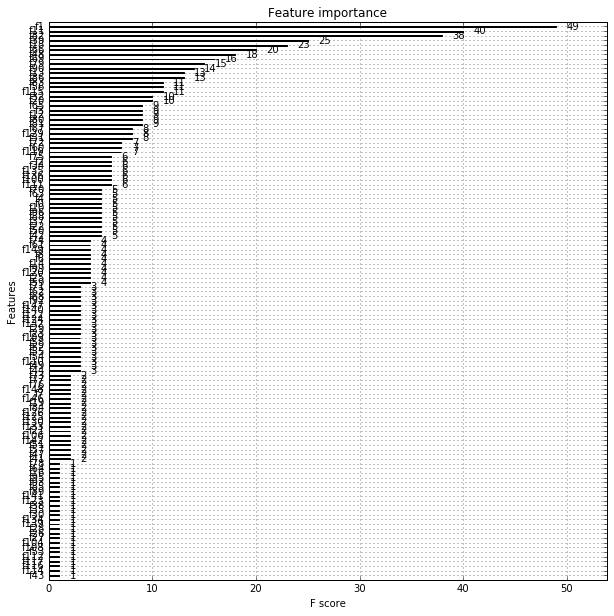

In [8]:
# experimenting with bigger pipeline

pipeline = Pipeline([
        ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
        ('std', StandardScaler()),
        ('pca', PCA(n_components=150))
    ])

pipeline = pipeline.fit(df_train)
X_train = pipeline.transform(df_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)
xgb = XGBClassifier(seed=0)
xgb = xgb.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)])

plot_importance(xgb)